In [42]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from collections import Counter
import pandas as pd

# Tạo thư mục results nếu chưa có
results_dir = '../results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

print("Thư viện đã tải thành công! - Bắt đầu phân tích lúc 12:26 PM, 17/10/2025")

Thư viện đã tải thành công! - Bắt đầu phân tích lúc 12:26 PM, 17/10/2025


Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_12775696.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_18699711.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_19321092.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_20374852.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_24299949.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_25953867.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_267631.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_27785233.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_28756096.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_29702802.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_30337890.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_31094469.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_3125398.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_31835561.jpg
Ảnh trùng lặp, bỏ qua: ../data/train\angry\Training_32342634.jpg
Ảnh trùng lặp, bỏ qua: ../da

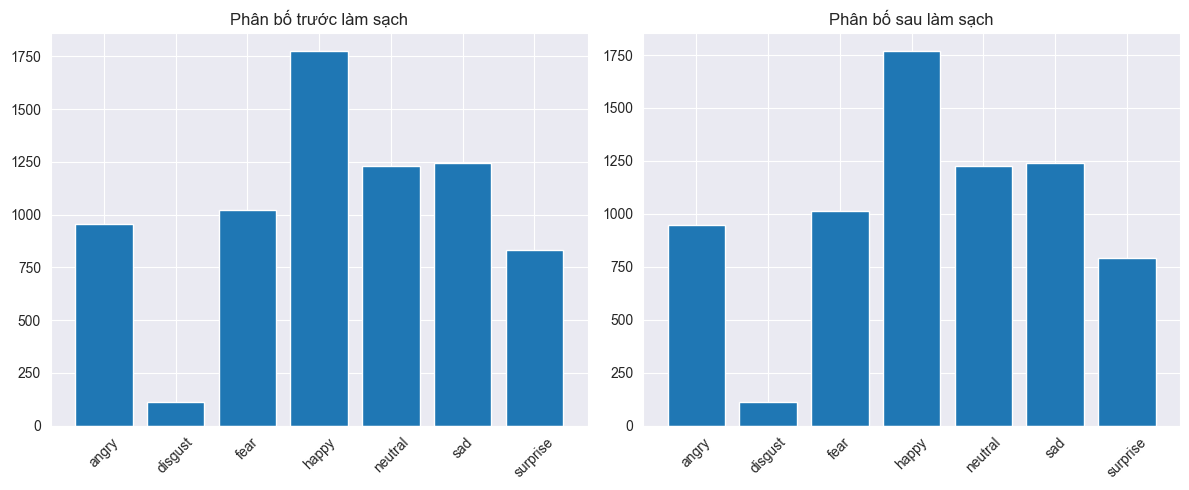

In [43]:
import hashlib

def clean_data(data_dir, output_dir, target_size=(48, 48)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cleaned_files = []
    corrupted_files = []
    seen_hashes = set()

    for emotion in os.listdir(data_dir):
        emotion_src_dir = os.path.join(data_dir, emotion)
        emotion_dest_dir = os.path.join(output_dir, emotion)
        if not os.path.exists(emotion_dest_dir):
            os.makedirs(emotion_dest_dir)

        for img_name in os.listdir(emotion_src_dir):
            img_path = os.path.join(emotion_src_dir, img_name)
            try:
                img = Image.open(img_path).convert('L')
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                img_data = np.array(img).tobytes()
                img_hash = hashlib.md5(img_data).hexdigest()
                if img_hash not in seen_hashes:
                    seen_hashes.add(img_hash)
                    cleaned_img_path = os.path.join(emotion_dest_dir, img_name)
                    img.save(cleaned_img_path)
                    cleaned_files.append(cleaned_img_path)
                else:
                    print(f"Ảnh trùng lặp, bỏ qua: {img_path}")
            except Exception as e:
                print(f"File lỗi, bỏ qua: {img_path} - Lỗi: {e}")
                corrupted_files.append(img_path)

    print(f"Tổng số file làm sạch: {len(cleaned_files)}")
    print(f"Số file lỗi: {len(corrupted_files)}")
    return cleaned_files

# Thực hiện làm sạch
train_cleaned_dir = '../data/train_cleaned'
test_cleaned_dir = '../data/test_cleaned'
train_files = clean_data('../data/train', train_cleaned_dir)
test_files = clean_data('../data/test', test_cleaned_dir)

# So sánh phân bố
def count_images(data_dir):
    counts = {}
    for emotion in os.listdir(data_dir):
        emotion_dir = os.path.join(data_dir, emotion)
        counts[emotion] = len(os.listdir(emotion_dir))
    return counts

original_counts = count_images('../data/test')
cleaned_counts = count_images(test_cleaned_dir)
print("Phân bố trước làm sạch:", original_counts)
print("Phân bố sau làm sạch:", cleaned_counts)

# Vẽ biểu đồ phân bố
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(original_counts.keys(), original_counts.values())
plt.title('Phân bố trước làm sạch')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.bar(cleaned_counts.keys(), cleaned_counts.values())
plt.title('Phân bố sau làm sạch')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'distribution_comparison.png'))
plt.show()

In [44]:
# Tải dữ liệu test đã làm sạch
X_test = []
y_test = []

for emotion in os.listdir(test_cleaned_dir):
    emotion_dir = os.path.join(test_cleaned_dir, emotion)
    for img_name in os.listdir(emotion_dir):
        img_path = os.path.join(emotion_dir, img_name)
        img = Image.open(img_path).convert('L')
        img_array = np.array(img) / 255.0
        img_array = img_array.reshape(48, 48, 1)
        X_test.append(img_array)
        y_test.append(emotion)

X_test = np.array(X_test)
y_test = np.array(y_test)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
true_labels = encoder.fit_transform(y_test)
emotions = encoder.classes_.tolist()

print("Danh sách cảm xúc:", emotions)
print("Phân bố nhãn test:", Counter(true_labels))

Danh sách cảm xúc: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Phân bố nhãn test: Counter({np.int64(3): 1767, np.int64(5): 1240, np.int64(4): 1225, np.int64(2): 1013, np.int64(0): 946, np.int64(6): 792, np.int64(1): 109})


In [45]:
# Tải mô hình
model = load_model('../models/fer2013_model.h5')

# Dự đoán
pred_probs = model.predict(X_test)
pred_labels = np.argmax(pred_probs, axis=1)

print("Nhãn thật :", np.unique(true_labels))
print("Nhãn dự đoán :", np.unique(pred_labels))

222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Nhãn thật duy nhất: [0 1 2 3 4 5 6]
Nhãn dự đoán duy nhất: [0 1 2 3 4 5 6]


Báo cáo phân loại:
              precision    recall  f1-score   support

       angry       0.41      0.60      0.49       946
     disgust       0.57      0.04      0.07       109
        fear       0.34      0.25      0.29      1013
       happy       0.84      0.77      0.80      1767
     neutral       0.49      0.62      0.55      1225
         sad       0.47      0.39      0.43      1240
    surprise       0.71      0.71      0.71       792

    accuracy                           0.56      7092
   macro avg       0.55      0.48      0.48      7092
weighted avg       0.57      0.56      0.56      7092

Độ chính xác: 0.5616187253243091


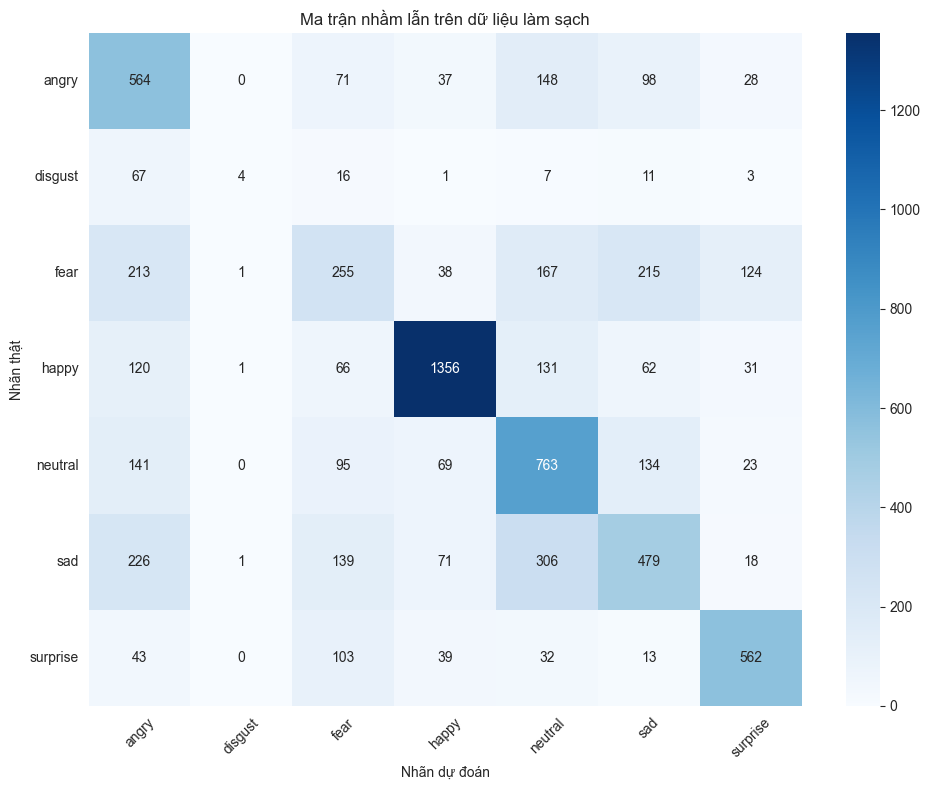

Phân tích hoàn tất! Kết quả được lưu trong thư mục 'results/'.


In [46]:
# Tạo báo cáo phân loại
report = classification_report(
    true_labels,
    pred_labels,
    labels=list(range(len(emotions))),
    target_names=emotions,
    output_dict=True,
    zero_division=0
)

# In báo cáo
print("Báo cáo phân loại:")
print(classification_report(true_labels, pred_labels, target_names=emotions, zero_division=0))
print("Độ chính xác:", report['accuracy'])

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotions, yticklabels=emotions, cmap='Blues')
plt.title('Ma trận nhầm lẫn trên dữ liệu làm sạch')
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thật')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'confusion_matrix_cleaned.png'))
plt.show()

# Lưu mô hình
model.save(os.path.join(results_dir, 'explore_model.h5'))
print("Phân tích hoàn tất! Kết quả được lưu trong thư mục 'results/'.")

Thống kê metric theo lớp:
       precision     recall   f1-score
count  10.000000  10.000000  10.000000
mean    0.552231   0.497554   0.492743
std     0.143111   0.220322   0.205804
min     0.342282   0.036697   0.068966
25%     0.477738   0.410102   0.438106
50%     0.555274   0.561619   0.517663
75%     0.570885   0.616191   0.560216
max     0.841713   0.767402   0.802842
Báo cáo đã được lưu thành file HTML.


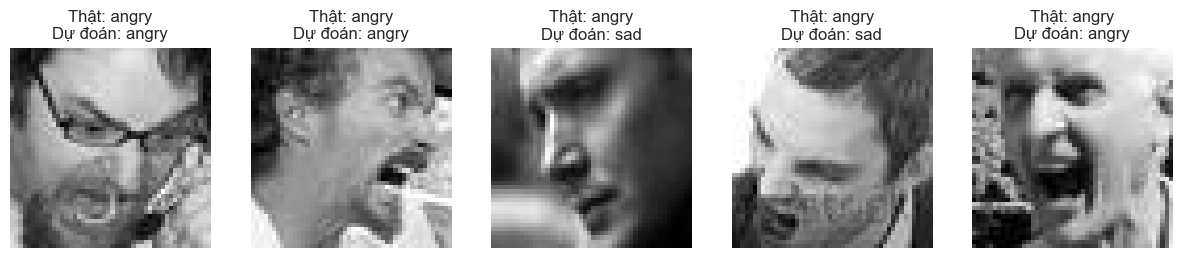

In [47]:
# Phân tích thống kê metric
report_df = pd.DataFrame(report).transpose()
print("Thống kê metric theo lớp:")
print(report_df[['precision', 'recall', 'f1-score']].describe())

# Lưu báo cáo thành file HTML
report_df.to_html(os.path.join(results_dir, 'classification_report.html'))
print("Báo cáo đã được lưu thành file HTML.")

# Hiển thị ảnh mẫu
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i].reshape(48, 48), cmap='gray')
    plt.title(f"Thật: {emotions[true_labels[i]]}\nDự đoán: {emotions[pred_labels[i]]}")
    plt.axis('off')
plt.savefig(os.path.join(results_dir, 'sample_images.png'))
plt.show()